In [1]:
import pymanopt
import numpy as np

dim=3

In [421]:
def random_cov():
    A = np.random.rand(dim-1, dim-1)
    return np.dot(A, A.transpose())

In [470]:
man = pymanopt.manifolds.Sphere(dim)
A = np.random.rand(dim-1, dim-1)/20
cov = np.dot(A, A.transpose())
mean = man.random_point()

In [471]:
mean, cov

(array([-0.32234691, -0.81603838,  0.47976436]),
 array([[0.00183044, 0.0019768 ],
        [0.0019768 , 0.0030393 ]]))

In [472]:
# generate tangent space
N = 100
samples = np.random.multivariate_normal(np.zeros(dim-1), cov, N)

In [473]:
# We need a tangent
normal = mean/np.linalg.norm(mean)

In [474]:
tol = 1e-5

def gram_schmidt(vectors):
    Q = np.zeros_like(vectors)
    for i in range(len(vectors)):
        v = vectors[i]
        for j in range(i):
            proj = np.dot(v, Q[j]) / np.dot(Q[j], Q[j]) * Q[j]
            v = v - proj
        Q[i] = v / np.linalg.norm(v)
    return Q
    
def get_axis(normal):
    # Assumes it is norm 1
    Q = np.eye(dim)
    arg = np.argmax(normal)
    if normal[arg]>(1-tol) and np.sum(normal)>(1-tol):
        return np.concatenate([Q[:arg], Q[arg+1:]])
    return gram_schmidt(np.vstack([normal,Q[:-1]]))[1:]

def get_e(i,n):
    return np.array(i*[0]+[1]+(n-i-1)*[0])

In [475]:
ax = get_axis(normal)

# Project points onto the axis to get all points in the tangent space
tangent_points = samples@ax

points = man.exp(mean, tangent_points)

In [476]:
# For estimateing normalisation constant
def estimate_normalising(mu, Sigma, manifold, m=None, S=100):
    d = manifold.dim
    z = np.sqrt((2*np.pi)**d*np.linalg.det(Sigma))
    samples = np.random.multivariate_normal(np.zeros(d), Sigma, S)
    vs = samples@ax
    return  z*np.mean(compute_vol(mu, vs, manifold, m))

sphere_M = lambda v: np.array([np.eye(v.shape[-1])]*len(v))

def compute_vol(mu, v, manifold, m=None):
    if m == None: m = sphere_M
    return np.sqrt(np.abs(np.linalg.det(m(manifold.exp(mu, v-mu)))))

In [477]:
def extrinsic_to_log(manifold, mu, x, ax):
    point = manifold.log(mu, x)
    return np.dot(point, ax.T)

In [625]:
def objective_grad_mu(points, mu, Sigma, ax, manifold, S=100):
    d = manifold.dim
    samples = np.random.multivariate_normal(np.zeros(d), Sigma, S)
    vs = samples@ax
    ms = compute_vol(mu, vs, manifold)
    z = np.sqrt((2*np.pi)**d*np.linalg.det(Sigma))
    grad = (np.array([extrinsic_to_log(manifold,mu,p,ax) for p in points])
             .mean(0)-z*(ms.reshape(1,-1)@samples)/
             (S*estimate_normalising(mu, Sigma, manifold)))
    return grad

def objective_grad_A(points, mu, Sigma, ax, manifold, S=100):
    d = manifold.dim
    vals, vecs = np.linalg.eig(Sigma)
    A = (vecs@np.diag(1/np.sqrt(vals))).T
    samples = np.random.multivariate_normal(np.zeros(d), Sigma, S)
    vs = samples@ax
    ms = compute_vol(mu, vs, manifold)
    term2 = np.zeros((d, d)).astype(dtype='float64')
    for m,s in zip(ms,samples):
        term2 += m*((s.reshape(-1,1))@(s.reshape(1,-1)))
    term2 *= np.sqrt((2*np.pi)**d*np.linalg.det(Sigma))
    term2 /= (S*estimate_normalising(mu, Sigma, manifold))
    term1 = np.zeros((d, d)).astype(dtype='float64')
    for p,v in zip(points,vs):
        log = extrinsic_to_log(manifold,mu,p,ax)
        term1 += (log.reshape(-1,1))@(log.reshape(1,-1))
    term1 /= len(points)
    return A@(term1-term2)

def objective(points, mu, Sigma, ax, manifold):
    d = manifold.dim
    result = 0
    inv = np.linalg.inv(Sigma)
    for p in points:
        log = extrinsic_to_log(manifold,mu,p,ax)
        result += np.dot(log, inv@log)
    result /= 2*len(points)
    return result + np.log(estimate_normalising(mu, Sigma, manifold))

def convergence_criteria(points, manifold, e=1e-5):
    x =  lambda mu0, Sigma0, mu, Sigma, ax: (objective(points, mu, Sigma, ax, manifold)-
                                         objective(points, mu0, Sigma0, ax, manifold))
    return (lambda mu0, Sigma0, mu, Sigma, ax: np.abs(x(mu, Sigma, mu0, Sigma0, ax))>e)
def mle_manifold(points, manifold, step_size_mu=5e-3, step_size_A=0):
    d = manifold.dim
    Sigma0 = random_cov()
    mu0 = manifold.random_point()
    Sigma = cov
    mu = manifold.random_point()
    criterion = convergence_criteria(points, manifold)
    count, max_loops = 0, 500
    ax = get_axis(mu)
    losses = []
    while criterion(mu0, Sigma0, mu, Sigma, ax) and count < max_loops:
        grad_mu = objective_grad_mu(points, mu, Sigma, ax, manifold)@ax
        mu0, Sigma0 = mu, Sigma
        mu = manifold.exp(mu0, step_size_mu*grad_mu)[0]
        vals, vecs = np.linalg.eig(Sigma)
        A = (vecs@np.diag(1/np.sqrt(vals))).T
        ax = get_axis(mu)
        grad_A = objective_grad_A(points, mu, Sigma0, ax, manifold)
        A -= step_size_A*grad_A
        Sigma = np.linalg.inv(A.T@A)
        losses.append(objective(points, mu, Sigma, ax, manifold))
        count += 1
    print(count)
    return mu, Sigma, losses
    
    

In [626]:
mu, Sigma, losses = mle_manifold(points, man)

500


In [627]:
import matplotlib.pyplot as plt

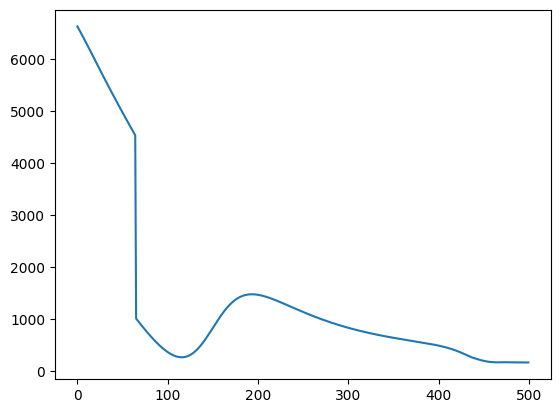

In [628]:
plt.plot(losses)

In [629]:
mu, Sigma

(array([-0.32499972, -0.8170592 ,  0.47622415]),
 array([[0.00183044, 0.0019768 ],
        [0.0019768 , 0.0030393 ]]))

In [624]:
mean

array([-0.32234691, -0.81603838,  0.47976436])

In [584]:

cov

array([[0.00183044, 0.0019768 ],
       [0.0019768 , 0.0030393 ]])